In [3]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

import os
import csv
import shutil
import glob
import time
import random
random.seed(0)

from itertools import cycle, product
from collections import OrderedDict

import numpy as np
np.random.seed(0)
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as albu
import seaborn as sns

import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import segmentation_models_pytorch as smp

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [4]:
DATA_DIR = './data/segmentation/ebc_exp1/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_annot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_annot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_annot')

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
MICRO_MODELS_DIR = './microscopynet_models/'

# Dictionaries with model paths
with open(os.path.join(MICRO_MODELS_DIR, 'microscopynet.csv'), mode='r') as infile:
    reader = csv.reader(infile)
    microscopynet_weights = {r[0]:r[1] for r in reader}
    
with open(os.path.join(MICRO_MODELS_DIR, 'microscopynet_fromscratch.csv'), mode='r') as infile:
    reader = csv.reader(infile)
    microscopynet_fromscratch_weights = {r[0]:r[1] for r in reader}


In [6]:
class Dataset_1_4_shift(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    Modified from https://github.com/qubvel/segmentation_models.pytorch
    
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (dict): values of classes to extract from segmentation mask. 
            Each dictionary value can be an integer or list that specifies the mask
            values that belong to the class specified by the corresponding dictionary key.
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_values,
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.class_values = class_values
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        xs = random.randint(-256, 256) #row shift
        ys = random.randint(-256, 256) #col shift
        
        # read data
        if i%4 == 0:
            image = cv2.imread(self.images_fps[i//4])[max(0,xs):512+max(0,xs), max(0,ys):512+max(0,ys)]
            mask = cv2.imread(self.masks_fps[i//4], 0)[max(0,xs):512+max(0,xs), max(0,ys):512+max(0,ys)]
        elif i%4 == 1:
            image = cv2.imread(self.images_fps[i//4])[max(0,xs):512+max(0,xs), 512+min(0,ys):1024+min(0,ys)]
            mask = cv2.imread(self.masks_fps[i//4], 0)[max(0,xs):512+max(0,xs), 512+min(0,ys):1024+min(0,ys)]
        elif i%4 == 2:
            image = cv2.imread(self.images_fps[i//4])[512+min(0,xs):1024+min(0,xs):, max(0,ys):512+max(0,ys)]
            mask = cv2.imread(self.masks_fps[i//4], 0)[512+min(0,xs):1024+min(0,xs), max(0,ys):512+max(0,ys)]
        elif i%4 ==3:
            image = cv2.imread(self.images_fps[i//4])[512+min(0,xs):1024+min(0,xs), 512+min(0,ys):1024+min(0,ys)]
            mask = cv2.imread(self.masks_fps[i//4], 0)[512+min(0,xs):1024+min(0,xs), 512+min(0,ys):1024+min(0,ys)]
            
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # extract certain classes from mask (e.g. precipitates)
        masks = [(np.isin(mask, v)) for v in self.class_values.values()]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)*4

#THIS IS THE QUARTERED DATASET WITH 512X512 INSTEAD OF 1024X1024
class Dataset_1_4(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    Modified from https://github.com/qubvel/segmentation_models.pytorch
    
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (dict): values of classes to extract from segmentation mask. 
            Each dictionary value can be an integer or list that specifies the mask
            values that belong to the class specified by the corresponding dictionary key.
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_values,
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.class_values = class_values
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        if i%4 == 0:
            image = cv2.imread(self.images_fps[i//4])[:512, :512]
            mask = cv2.imread(self.masks_fps[i//4], 0)[:512, :512]
        elif i%4 == 1:
            image = cv2.imread(self.images_fps[i//4])[:512, 512:]
            mask = cv2.imread(self.masks_fps[i//4], 0)[:512, 512:]
        elif i%4 == 2:
            image = cv2.imread(self.images_fps[i//4])[512:, :512]
            mask = cv2.imread(self.masks_fps[i//4], 0)[512:, :512]
        elif i%4 ==3:
            image = cv2.imread(self.images_fps[i//4])[512:, 512:]
            mask = cv2.imread(self.masks_fps[i//4], 0)[512:, 512:]
            
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        

        # extract certain classes from mask (e.g. cars)
        masks = [(np.isin(mask, v)) for v in self.class_values.values()]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)*4

In [7]:
def get_training_augmentation():
    train_transform = [
        #albu.Resize(height,width),
        albu.HorizontalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=25, shift_limit=0.1, p=1, border_mode=0),

        
        #albu.RandomCrop(height=512, width=512, p=0.25),
        #albu.PadIfNeeded(min_height=height, min_width=320, always_apply=True, border_mode=0),
        #albu.IAAPerspective(p=0.5),
        
        
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.OneOf(
            [
                #albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                #albu.RandomGamma(p=1),
            ],
            p=0.25,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=2, p=1),
                #albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.25,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1)#,
                #albu.HueSaturationValue(p=1),
            ],
            p=0.25,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #albu.Resize(height,width)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [8]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.weight = weight
        self.__name__ = 'DiceBCELoss'

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = self.weight * BCE + (1-self.weight) * dice_loss
        
        return Dice_BCE

In [9]:
def remove_module_from_state_dict(state_dict):
    """Removes 'module.' from nn.Parallel models.  
    If module does not exist it just returns the state dict"""
    if list(state_dict.keys())[0].startswith('module'):
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v           
        return new_state_dict
    elif list(state_dict.keys())[0].startswith('features.module'):
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[:9] + k[9+7:] # remove `module.`
            if name.startswith('features.'):
                new_state_dict[name] = v
        return new_state_dict
    else:
        return state_dict


In [53]:
def train_model(decoder, encoder, encoder_weights, class_values, device='cuda', lr=2e-4, lr_decay=0.01,
               batch_size=20, val_batch_size=12, num_workers=0, patience=30, save_folder='./', multi_gpu=False, step_lr=None):
    print(decoder, encoder, encoder_weights)
    # setup and check parameters
    assert len(class_values) != 2, "Two classes is binary classification.  Just specify the posative class value"
    activation = 'softmax2d' if len(class_values) > 1 else 'sigmoid' #'softmax2d' for multicalss segmentation
    initial_weights = None if encoder_weights is None else 'imagenet'
    # load model
    
    if initial_weights == 'imagenet' and ('dpn68b' in encoder or 'dpn92' in encoder or 'dpn137' in encoder
                                         or 'dpn107' in encoder):
        initial_weights = 'imagenet+5k'
    
    try:
        model = getattr(smp, decoder)(encoder_name=encoder, 
                                      encoder_weights=initial_weights,
                                      classes=len(class_values),
                                      activation=activation)
    except ValueError: #certain encoders do not support encoder dilation
        if decoder == 'DeepLabV3Plus':
            print('\n\n%s does not support dilated mode needed for %s. Skipping.\n\n' %(encoder, decoder))
            return
        else:
            model = getattr(smp, decoder)(encoder_name=encoder, 
                                          encoder_weights=initial_weights,
                                          classes=len(class_values),
                                          activation=activation,
                                          encoder_dilation=False)
        
        
    # load pretrained weights 
    if encoder_weights in ['microscopynet', 'microscopynet_fromscratch']:
        # load the saved state dict
        try:
            if encoder_weights == 'microscopynet':
                path = os.path.join(MICRO_MODELS_DIR, microscopynet_weights[encoder])
            else:
                path = os.path.join(MICRO_MODELS_DIR, microscopynet_fromscratch_weights[encoder])
        except KeyError:
            print('\n\nNo pretrained %s weights for %s encoder!!\n\n' %(encoder, encoder_weights))
            return
        state_dict = torch.load(path)['state_dict']    
        
        # remove module. from keys if trained with DataParallel
        state_dict = remove_module_from_state_dict(state_dict)
        
        # fix last_linear.bias and last_linear weigths for xception pretrained
        if encoder == 'xception':
            new_state_dict = OrderedDict()
            for k, v in state_dict.items():
                name = k.replace('last_linear', 'fc')
                new_state_dict[name] = v    
            state_dict = new_state_dict
        
        model.encoder.load_state_dict(state_dict)
        
    if multi_gpu:
        model = torch.nn.DataParallel(model).cuda()

    # create dataloaders
    try:
        preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet')
    except ValueError:
        preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet+5k')
        
    train_dataset = Dataset_1_4_shift(
        x_train_dir, 
        y_train_dir, 
        augmentation=get_training_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        class_values=class_values,
    )

    valid_dataset = Dataset_1_4(
        x_valid_dir, 
        y_valid_dir, 
        augmentation=get_validation_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        class_values=class_values,
    )
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=num_workers, pin_memory=True)  
    valid_loader = DataLoader(valid_dataset, batch_size=val_batch_size, 
                              shuffle=False, num_workers=num_workers, pin_memory=True)
    
    loss = DiceBCELoss(weight=0.7)

    metrics = [smp.utils.metrics.IoU(threshold=0.5),]
    
    optimizer = torch.optim.Adam([ 
        dict(params=model.parameters(), lr=lr),])
    
    # create epoch runners 
    # it is a simple loop of iterating over dataloader`s samples
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=device,
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=device,
        verbose=True,
    )
    
    patience_step = 0
    max_score = 0
    best_epoch = 0
    epoch = 0
    t0 = time.time()

    state = {'encoder': encoder,
             'decoder': decoder,
             'train_loss': [],
             'valid_loss': [],
             'train_iou': [],
             'valid_iou': [],
             'max_score': 0,
             'class_values': class_values
            }
    
    while True:
        t = time.time() - t0
        print('\nEpoch: {}, lr: {:0.8f}, time: {:0.2f} seconds, patience step: {}, best iou: {:0.4f}'.format(
            epoch, lr, t, patience_step, max_score))
        t0 = time.time()
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        # update the state
        state['epoch'] = epoch + 1
        state['state_dict'] = model.state_dict()
        state['optimizer'] = optimizer.state_dict()
        state['train_loss'].append(train_logs['DiceBCELoss'])
        state['valid_loss'].append(valid_logs['DiceBCELoss'])
        state['train_iou'].append(train_logs['iou_score'])
        state['valid_iou'].append(valid_logs['iou_score'])
        
        # save the model
        #torch.save(state, os.path.join(save_folder, 'checkpoint.pth.tar'))
        
        # do something (save model, change lr, etc.)
        if max_score < valid_logs['iou_score']:
            patience_step = 0
            max_score = valid_logs['iou_score']
            best_epoch = epoch + 1
#             shutil.copyfile(os.path.join(save_folder, 'checkpoint.pth.tar'), 
#                             os.path.join(save_folder, 'model_best.pth.tar'))
            torch.save(state, os.path.join(save_folder, 'model_best.pth.tar'))
            print('Best model saved!')
        
        else:
            patience_step += 1

        
        # Increment the epoch and decay the learning rate
        epoch += 1
        lr = optimizer.param_groups[0]['lr'] * (1-lr_decay)
        optimizer.param_groups[0]['lr'] = lr
        
        if step_lr is not None and epoch == 25:
            lr = step_lr
            optimizer.param_groups[0]['lr'] = lr
            
        # Use early stopping if there has not been improvment in a while
        if patience_step > patience:
            print('\n\nTraining done!  No improvement in {} epochs. Saving final model'.format(patience))
            shutil.copyfile(os.path.join(save_folder, 'model_best.pth.tar'), 
                            os.path.join(save_folder, '{}__{}__{}__{}__{:.3f}.pth.tar'.format(
                                decoder, encoder, encoder_weights, best_epoch, max_score)))
            break

    

### Train 1st set with all decoders, all pretraining weights, and limited encoders

In [59]:
decoders = ['Unet', 'FPN', 'Linknet', 'PSPNet', 'PAN', 'DeepLabV3Plus']
# encoders_no_run = ['resnext101_32x32d', 'resnext101_32x48d', 'efficientnet-b6', 
#              'efficientnet-b7', 'resnext101_32x16d', 'resnext101_32x32d',
#             'resnext101_32x48d', 'vgg16', 'vgg19', 'vgg19_bn', 'vgg13', 'vgg11'] 
# encoders = [e for e in smp.encoders.get_encoder_names() if e not in encoders_no_run]
encoders = [key for key in microscopynet_fromscratch_weights]
encoder_weights = [None, 'imagenet', 'microscopynet', 'microscopynet_fromscratch']
class_values = {'background': 0,
                'oxide': 1,
                'crack': 2}


In [ ]:
for e, d, ew in product(encoders, decoders, encoder_weights):
    train_model(d, e, ew, class_values, 
                save_folder='./segmentation_models/ebc_exp1', 
                multi_gpu=True,
                num_workers=2,
                patience=30,
               lr_decay=0.00,
               step_lr=1e-5)

### Train 2nd set with all decoders, just imagenet and microscopynet weights, and all encoders

In [56]:
decoders = ['Unet', 'FPN', 'Linknet', 'PSPNet', 'PAN', 'DeepLabV3Plus']

old_encoders = [key for key in microscopynet_fromscratch_weights]
encoders_no_run = ['resnext101_32x32d', 'resnext101_32x48d', 'efficientnet-b6', 
             'efficientnet-b7', 'resnext101_32x16d', 'resnext101_32x32d',
            'resnext101_32x48d', 'vgg16', 'vgg19', 'vgg19_bn', 'vgg13', 'vgg11',
                  'timm-efficientnet-b0', 'timm-efficientnet-b1', 'timm-efficientnet-b2', 
                   'timm-efficientnet-b3', 'timm-efficientnet-b4', 'timm-efficientnet-b5', 
                   'timm-efficientnet-b6', 'timm-efficientnet-b7', 'timm-efficientnet-b8', 'timm-efficientnet-l2'] 
encoders_no_run = encoders_no_run + old_encoders
encoders = [e for e in smp.encoders.get_encoder_names() if e not in encoders_no_run]

encoder_weights = ['imagenet', 'microscopynet']
class_values = {'background': 0,
                'oxide': 1,
                'crack': 2}

i = 0
for i, (e, d, ew) in enumerate(product(encoders, decoders, encoder_weights)):
    if i >= 370:
        train_model(d, e, ew, class_values, 
                    save_folder='./segmentation_models/ebc_exp1', 
                    multi_gpu=True,
                    num_workers=2,
                    patience=30,
                   lr_decay=0.00,
                   step_lr=1e-5)
        #print(i, e, d, ew)


DeepLabV3Plus xception imagenet


xception does not support dilated mode needed for DeepLabV3Plus. Skipping.


DeepLabV3Plus xception microscopynet


xception does not support dilated mode needed for DeepLabV3Plus. Skipping.




## Test model

In [61]:
#best_model = torch.load('./segmentation_models/ebc_exp1/model_best.pth.tar')
best_model = torch.load('./segmentation_models/ebc_exp1/Unet__inceptionresnetv2__microscopynet__200__0.981.pth.tar')

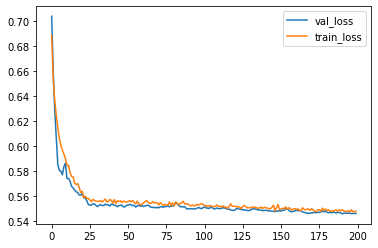

In [62]:
# for key in best_model:
#     print(key)
x = range(len(best_model['valid_loss']))    
plt.plot(x, best_model['valid_loss'], label='val_loss')
plt.plot(x, best_model['train_loss'], label='train_loss')
plt.legend()
plt.show()
#print(best_model['train_iou'])

In [69]:
DEVICE = 'cuda'
decoder = best_model['decoder']
encoder = best_model['encoder']
#class_values = best_model['class_values']
class_values = {'background': 0,
                'oxide': 1,
                'crack': 2}
activation = 'softmax2d' if len(class_values) > 1 else 'sigmoid' #'softmax2d' for multicalss segmentation
print(encoder, decoder)
try:
    preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet')
except ValueError:
    preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet+5k')
model = getattr(smp, decoder)(encoder_name=encoder, 
                                      encoder_weights=None,
                                      classes=len(class_values),
                                      activation=activation)

model.load_state_dict(remove_module_from_state_dict(best_model['state_dict']))

inceptionresnetv2 Unet


<All keys matched successfully>

In [70]:
# create test dataset
test_dataset = Dataset_1_4(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_values=class_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset without transformations for image visualization
test_dataset_vis = Dataset_1_4(
    x_test_dir, y_test_dir, 
    class_values=class_values,
)

In [71]:
# evaluate model on test set
loss = DiceBCELoss(weight=0.7)
metrics = [smp.utils.metrics.IoU(threshold=0.5),]
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device='cuda',
)

logs = test_epoch.run(test_dataloader)

valid:  33%|███▎      | 4/12 [00:00<00:00, 14.05it/s, DiceBCELoss - 0.5461, iou_score - 0.982] 

/home/jstuckne/.conda/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid: 100%|██████████| 12/12 [00:00<00:00, 15.19it/s, DiceBCELoss - 0.5462, iou_score - 0.9814]


### Visualize results 

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask_background = gt_mask[0].squeeze()
    gt_mask_oxide = gt_mask[1].squeeze()
    gt_mask_crack = gt_mask[2].squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)


    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask_oxide = pr_mask[1].squeeze()
    pr_mask_crack = pr_mask[2].squeeze()
    
    
    
    pr_mask_background = pr_mask[0].squeeze()
        
    visualize(
        image=image_vis, 
        ground_truth_oxide=gt_mask_oxide,
        predicted_oxide=pr_mask_oxide,
        ground_truth_crack=gt_mask_crack,
        predicted_crack=pr_mask_crack
    )